In [204]:
#Импортируем базовые библиотеки
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [205]:
import warnings
warnings.filterwarnings("ignore")

In [206]:
#Загружаем Antifraud датасет и выводим первые 5 строк
df = pd.read_csv('creditcard.csv')
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [207]:
#Смотрим размер датафрейма
df.shape

(284807, 31)

In [208]:
#Фиксируем состояние генератора случайных чисел, чтобы воспроизводить результаты модель
SEED = 39 # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

In [209]:
#Время в секундах непонятно, добавим часы - остаток от суток поделенный нацело на часы
df['Hour'] = (df['Time'] % 86400) // 3600

In [210]:
#добавим циклическую кодировку времени через синус и косинус одновременно для улавливания ближайших четвертей суток
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)

In [211]:
#Смотрим типы данных и кол-во заполненных ячеек
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 34 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Time      284807 non-null  float64
 1   V1        284807 non-null  float64
 2   V2        284807 non-null  float64
 3   V3        284807 non-null  float64
 4   V4        284807 non-null  float64
 5   V5        284807 non-null  float64
 6   V6        284807 non-null  float64
 7   V7        284807 non-null  float64
 8   V8        284807 non-null  float64
 9   V9        284807 non-null  float64
 10  V10       284807 non-null  float64
 11  V11       284807 non-null  float64
 12  V12       284807 non-null  float64
 13  V13       284807 non-null  float64
 14  V14       284807 non-null  float64
 15  V15       284807 non-null  float64
 16  V16       284807 non-null  float64
 17  V17       284807 non-null  float64
 18  V18       284807 non-null  float64
 19  V19       284807 non-null  float64
 20  V20 

In [212]:
#1 пропущенная строка без разметки класса и amount, выкинем её
df = df.dropna()

In [213]:
#Смотрим на пропуски - их нет, поэтому обойдемся без Imputer()
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [214]:
#Смотрим доли классов для соблюдения баланса далее
df.Class.value_counts(normalize = True)

,proportion
Class,
0,0.998273
1,0.001727


Проверка на корректность

In [215]:
df.duplicated().sum()

np.int64(1081)

In [216]:
#Удаляем полные дубликаты строк и смотрим, уменьшилось ли кол-во
print(f'Старое число строк {df.shape[0]}')
df = df.drop_duplicates()
print(f'Новое число строк {df.shape[0]}')

Старое число строк 284807
Новое число строк 283726


In [217]:
#Смотрим остались ли дубликаты
df.duplicated().any()

np.False_

In [218]:
#Разные перцентили числовых признаков
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,Hour,Hour_sin,Hour_cos
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667,14.045646,-0.244310,-0.174533
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796,5.834817,0.650603,0.697545
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000,0.000000,-1.000000,-1.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000,10.000000,-0.866025,-0.866025
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000,15.000000,-0.500000,-0.258819
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000,19.000000,0.258819,0.500000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000,23.000000,1.000000,1.000000


In [219]:
#Убедимся, что нет отрицательных значений Amount
(df.Amount < 0).sum()

np.int64(0)

Тщательное изучение признаков

<Axes: xlabel='Time', ylabel='Count'>

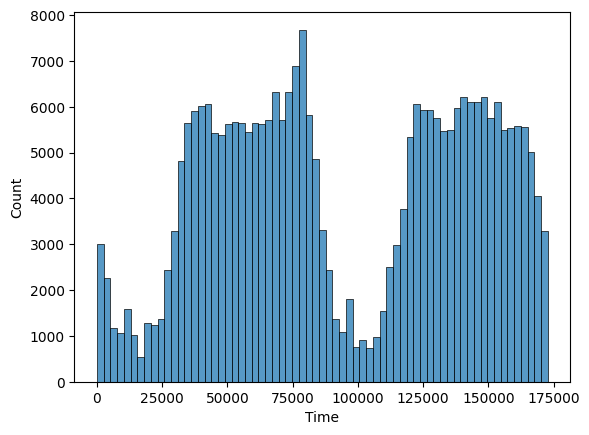

In [220]:
#Распределение времени похоже на два колокола - намек на мультимодальность
sns.histplot(df.Time)

Периодичность возникла из-за смещения на сутки и добавления к новой выборке 86400 секунд. Посмотрим, исчезает ли это в часах?

<Axes: xlabel='Hour', ylabel='Count'>

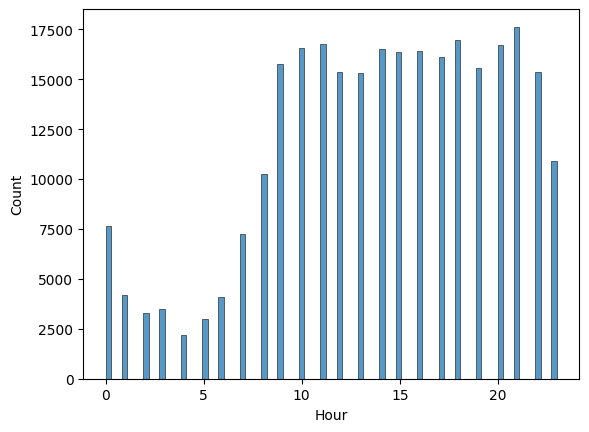

In [221]:
#Тут уже все выглядит сильно лучше с намеком на Uniform распределение (почти, начиная с 9 часов)
sns.histplot(df.Hour)

In [222]:
#Так как в Amount огромные выбросы, посмотрим 95% значений на масштабированной гистограмме
amount_crit = np.quantile(df.Amount, 0.95)
amount_crit

np.float64(365.33750000000003)

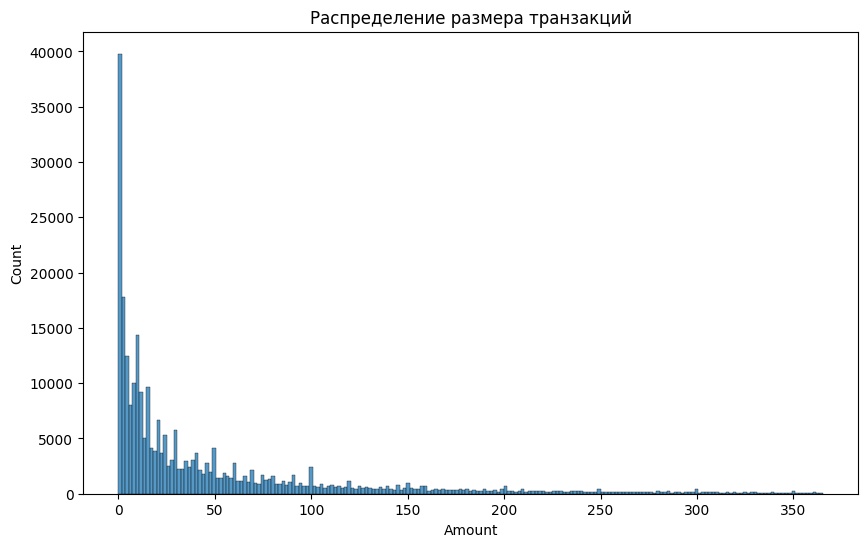

In [223]:
amount_95 = df.Amount[df.Amount < amount_crit]
plt.figure(figsize = [10, 6])
sns.histplot(amount_95)
plt.title('Распределение размера транзакций')
plt.show()

Посмотрим взаимосвязь времени суток и мошеннических операций с помощью группировки этих признаков и сортировки в убывающем порядке.

In [224]:

hour_fraud = df.groupby('Hour')['Class'].mean().sort_values(ascending = False)
hour_fraud*100 #в процентах проще сравнивать

,Class
Hour,
2.0,1.451028
4.0,1.043557
3.0,0.487525
5.0,0.368139
7.0,0.317987
11.0,0.315833
1.0,0.237643
6.0,0.220480
17.0,0.173590


Как видим, пик мошенничества приходится на 2-5 утра, что может быть связно с потерей бдительности людьми ночью или отсутсвием надзора.

In [225]:
#Сравним распределения сумм в двух классах
df.groupby('Class')['Amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,283253.0,88.413575,250.379023,0.0,5.67,22.00,77.46,25691.16
1,473.0,123.871860,260.211041,0.0,1.00,9.82,105.89,2125.87


Транзакция мошенников в среднем 123.9 против 88.4 'здоровой'

<Axes: >

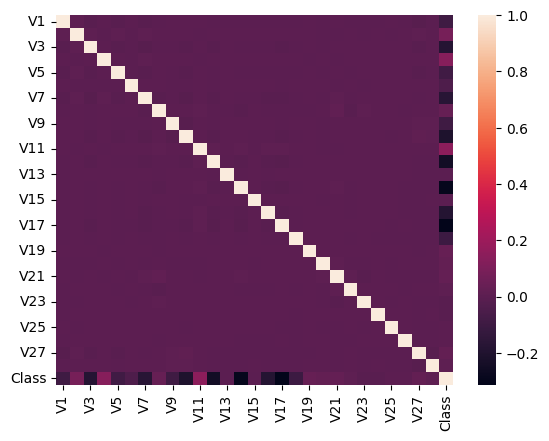

In [226]:
#Рассмотрим корреляцию признаков V между собой и с наличием  мошенничества
v_cols = [c for c in df.columns if c.startswith('V')]
corr_v_class = df[v_cols + ['Class']].corr()
sns.heatmap(corr_v_class)

In [227]:
#Введем функцию для поиска максимальных абсолютных значений корреляции
top_n = 10
def correlations(df, top_n):
  print('Абсолютные корреляции по убыванию')
  corr_df = df.corr()
  corr_no_diag = corr_df.mask(np.eye(len(corr_df), dtype=bool))
  top_corrs = corr_no_diag.abs().stack().sort_values(ascending=False).head(top_n)
  print(top_corrs)

In [228]:
#Видим, что абсолютные значения корреляций не превышают 0.32, а значит линейно признакимы не зависимы
corr_df = df[v_cols + ['Class']]
correlations(corr_df, 10)

Абсолютные корреляции по убыванию
Class  V17      0.313498
V17    Class    0.313498
V14    Class    0.293375
Class  V14      0.293375
       V12      0.250711
V12    Class    0.250711
Class  V10      0.206971
V10    Class    0.206971
V16    Class    0.187186
Class  V16      0.187186
dtype: float64


In [229]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Hour', 'Hour_sin', 'Hour_cos'],
      dtype='object')

In [230]:
#Разбили на 5 равных квантилей (0,25,50,75,100 и присвоили размер суммы) и заменили Amount на 5 категорий по квантилю. Переведем категории в числа сразу

df['Amount_Category'] = pd.qcut(
    df['Amount'],
    q=5,
    labels=[1, 2, 3, 4, 5],
    duplicates='drop'
)
df.Amount_Category.value_counts()
df['Amount_Category'] = df['Amount_Category'].values.to_numpy()
df['Amount_Category'].value_counts(normalize = True)

,proportion
Amount_Category,
4,0.201184
1,0.200873
3,0.200035
2,0.199129
5,0.198780


<Axes: >

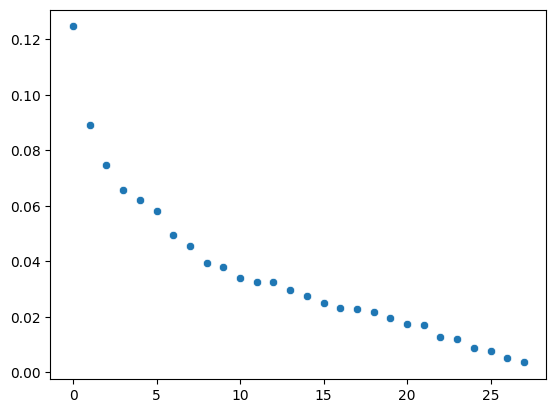

In [231]:
from sklearn.decomposition import PCA
pca = PCA()
cols = df[v_cols].copy()
pca.fit_transform(cols)
sns.scatterplot(pca.explained_variance_ratio_)

Обучение моделей и сравнение.

In [232]:
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score)
df_metrics = pd.DataFrame()
def eval_model(model, X_train, X_test, y_train, y_test, name):
    # Вычисляем метрики
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Создаем серию с результатами
    metrics_series = pd.Series({
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'ROC-AUC': roc_auc
    }, name=name)

    # Добавляем эту серию как новый столбец в df_metrics
    # Если индекс df_metrics совпадает с метриками, то просто добавляем столбец
    # Иначе подгоняем индексы по названию (через reindex)
    df_metrics[name] = metrics_series.reindex(df_metrics.index)

    # Можно вывести значения для контроля
    print(metrics_series)

    return df_metrics

In [233]:
#Разбиваем на обучающую и тестовую выборки с test_size по умолчанию 0.8 и без перемешек (датасет сортирован по времени и временной конец будет в конце)
X = df.drop(columns = ['Class'])
y = df.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 39, shuffle = False)

In [234]:
train_idx = int(X.shape[0]*0.8)
class_1_train = df.iloc[:train_idx,:].Class.value_counts(normalize=True)[1]
class_1_train

np.float64(0.0017578641289981497)

In [235]:
class_1_test = df.iloc[train_idx:,:].Class.value_counts(normalize=True)[1]
class_1_test

np.float64(0.0013040566735981391)

In [236]:
#Доля на которую попробуем уменьшить миноритарный класс
prop_reduced = 1 - class_1_test/class_1_train
prop_reduced

np.float64(0.2581584366583819)

In [237]:
pos_idx = y_train[y_train == 1].index

# Количество удаляемых экземпляров (например, 20%)
remove_n = int(len(pos_idx) * 0.2)

# Случайный выбор
remove_idx = np.random.choice(pos_idx, size=remove_n, replace=False)

# Удаляем из train и y_train
X_train_red = X_train.drop(index=remove_idx)
y_train_red = y_train.drop(index=remove_idx)
X_train_red.shape, X_train.shape

((212718, 34), (212794, 34))

In [238]:
#Нормирование с учетом выбросов и без data leakage! Test не должен учитываться при обучении train (иначе запомнит выборку)
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train[['Time','Hour', 'Amount','Amount_Category']] = scaler.fit_transform(X_train[['Time','Hour', 'Amount','Amount_Category']])
X_test[['Time', 'Hour','Amount','Amount_Category']] = scaler.transform(X_test[['Time', 'Hour','Amount','Amount_Category']])
X_test.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Hour,Hour_sin,Hour_cos,Amount_Category
269134,1.390118,0.327338,0.147343,-0.100280,-2.050332,0.223306,-0.975126,0.525372,-0.160708,-1.480479,...,-0.370201,-0.340181,-0.384868,0.017932,0.015844,-0.282409,1.125,-0.707107,7.071068e-01,-1.0
256658,1.304588,2.033664,-0.083339,-1.173055,0.211190,0.149599,-0.604364,0.093874,-0.169101,0.228032,...,-0.381990,-0.283075,0.202297,-0.068615,-0.072913,-0.287957,0.875,-0.965926,2.588190e-01,-1.0
269166,1.390416,-0.331230,0.405236,-0.627084,-0.585115,0.509297,-1.265899,2.113501,-0.501493,-0.545434,...,-0.104093,-0.075246,0.162003,0.049857,0.181439,2.165223,1.125,-0.707107,7.071068e-01,1.0
248984,1.250846,-17.678628,-25.041752,-3.780019,7.928090,17.471828,-13.591286,-10.532208,1.480096,0.553701,...,1.322373,-1.400529,-0.670069,0.869406,-3.491490,1.654398,0.750,-1.000000,-1.836970e-16,1.0
231645,1.141742,2.039471,0.292844,-1.495567,0.734482,0.209526,-1.361885,0.333150,-0.387349,0.333741,...,-0.045302,-0.231108,0.011557,-0.036885,-0.027626,-0.253992,0.500,-0.866025,-5.000000e-01,-0.5


In [239]:
X_train.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Hour,Hour_sin,Hour_cos,Amount_Category
46059,-0.409577,-0.604374,0.631387,-0.100529,-1.591018,1.850567,3.455752,-0.508616,1.426039,-0.343051,...,0.996694,-0.207979,0.149825,-0.111239,-0.020897,-0.044249,-0.125,0.258819,-0.965926,0.0
172293,0.757518,-0.786459,0.627397,-0.941312,-0.629847,1.116954,-0.450213,0.586059,0.235849,0.015790,...,0.062124,-0.361054,0.087643,-0.307674,-0.200493,-0.044114,-0.375,0.707107,-0.707107,0.0
174317,0.769751,0.202920,0.562134,0.447962,-0.033656,0.383062,-0.858800,0.587135,-0.235359,-0.049592,...,0.138990,-0.451097,0.560636,0.111426,0.102770,-0.313261,-0.375,0.707107,-0.707107,-1.0
161047,0.650125,1.862303,-0.393318,-0.599153,1.210966,-0.284624,-0.021395,-0.412104,-0.005306,0.964992,...,-0.790142,-0.032991,-0.518788,0.044726,-0.025575,0.754263,-0.625,0.965926,-0.258819,0.5
111690,0.032541,-4.198735,0.194121,-3.917586,3.920748,-1.875486,-2.118933,-3.614445,1.687884,-2.189871,...,0.292539,-0.144967,-0.251744,1.249414,-0.131525,2.917997,1.000,-0.866025,0.500000,1.0


In [240]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Hour', 'Hour_sin', 'Hour_cos', 'Amount_Category'],
      dtype='object')

In [241]:
scaler_red = RobustScaler()
scaler_red.fit_transform(X_train_red[['Time','Hour', 'Amount_Category']])
X_test_red = X_test.copy()
X_test_red[['Time', 'Hour','Amount_Category']] = scaler_red.transform(X_test_red[['Time', 'Hour','Amount_Category']])

In [242]:
correlations(X_train, 10)

Абсолютные корреляции по убыванию
Hour_sin         Hour               0.762907
Hour             Hour_sin           0.762907
V2               Amount             0.545125
Amount           V2                 0.545125
                 Amount_Category    0.426995
Amount_Category  Amount             0.426995
V2               Amount_Category    0.395092
Amount_Category  V2                 0.395092
Amount           V20                0.390713
V20              Amount             0.390713
dtype: float64


Корреляция hour_sin и hour 0.76, поэтому будем оставлять что-то одно

In [244]:
# log_reg = LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=100)
log_reg = LogisticRegression(class_weight='balanced', max_iter = 50)
time_variants = [
    ['Time'],
    ['Hour'],
    ['Hour_sin', 'Hour_cos']
]

amount_variants = ['Amount', 'Amount_Category']

for time_cols in time_variants:
    for amount_col in amount_variants:
        cols_to_keep = time_cols + [amount_col] + v_cols
        cols_keep = time_cols + [amount_col]

        X_train_try = X_train[cols_to_keep]
        X_test_try = X_test[cols_to_keep]
        print(f"\nКомбинация: {cols_keep}")
        print(f'Результаты без undersampling')
        eval_model(log_reg, X_train_try, X_test_try,y_train, y_test, 'log_reg')
        print(f'Результаты c undersampling')
        eval_model(log_reg, X_train_red, X_test_red,y_train_red, y_test, 'log_reg_red')


Комбинация: ['Time', 'Amount']
Результаты без undersampling
Precision    0.064184
Recall       0.870968
F1-score     0.119557
ROC-AUC      0.981482
Name: log_reg, dtype: float64
Результаты c undersampling
Precision    0.001740
Recall       1.000000
F1-score     0.003475
ROC-AUC      0.976090
Name: log_reg_red, dtype: float64

Комбинация: ['Time', 'Amount_Category']
Результаты без undersampling
Precision    0.062992
Recall       0.860215
F1-score     0.117388
ROC-AUC      0.980968
Name: log_reg, dtype: float64
Результаты c undersampling
Precision    0.001740
Recall       1.000000
F1-score     0.003475
ROC-AUC      0.976090
Name: log_reg_red, dtype: float64

Комбинация: ['Hour', 'Amount']
Результаты без undersampling
Precision    0.029157
Recall       0.903226
F1-score     0.056490
ROC-AUC      0.981486
Name: log_reg, dtype: float64
Результаты c undersampling
Precision    0.001740
Recall       1.000000
F1-score     0.003475
ROC-AUC      0.976090
Name: log_reg_red, dtype: float64

Комбин

Результаты либо выдабт precision около 0 и почти единичный recall, либо наоборот. Не помогает регуляризация l1, l2 или elastic_net.

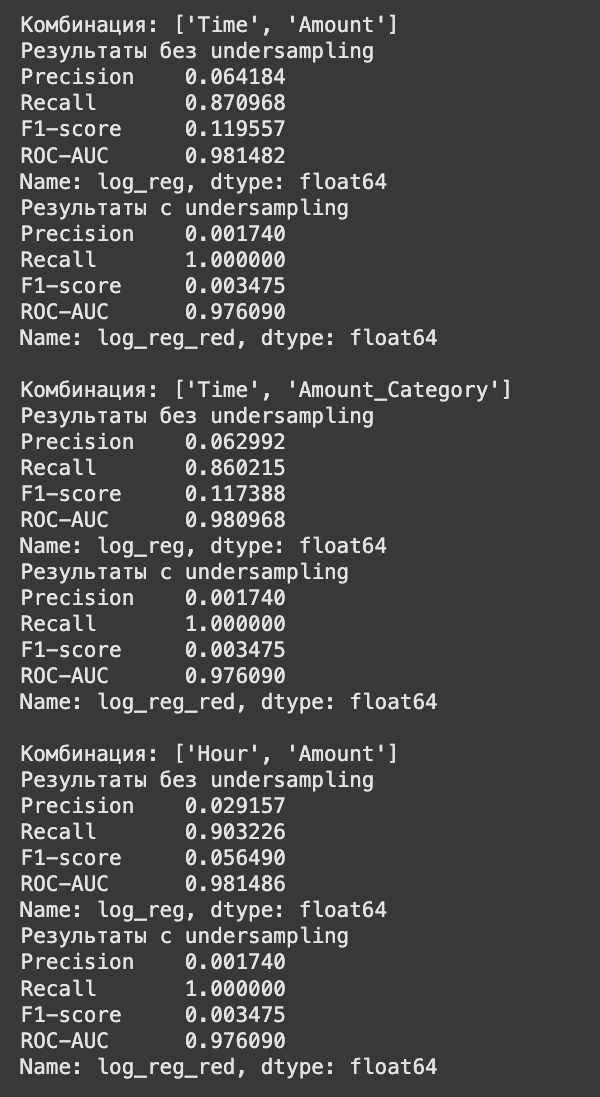

In [245]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=39)

for time_cols in time_variants:
    for amount_col in amount_variants:
        cols_to_keep = time_cols + [amount_col] + v_cols
        cols_keep = time_cols + [amount_col]
        X_train_try = X_train[cols_to_keep]
        X_test_try = X_test[cols_to_keep]
        print('Результаты случайного леса')
        print(f"\nКомбинация: {cols_keep}")
        print(f'Результаты без undersampling')
        eval_model(rf, X_train_try, X_test_try,y_train, y_test, 'rf')
        print(f'Результаты c undersampling')
        eval_model(rf, X_train_red, X_test_red,y_train_red, y_test, 'rf_red')


Результаты случайного леса

Комбинация: ['Time', 'Amount']
Результаты без undersampling
Precision    0.984848
Recall       0.698925
F1-score     0.817610
ROC-AUC      0.907819
Name: rf, dtype: float64
Результаты c undersampling
Precision    0.968254
Recall       0.655914
F1-score     0.782051
ROC-AUC      0.921188
Name: rf_red, dtype: float64
Результаты случайного леса

Комбинация: ['Time', 'Amount_Category']
Результаты без undersampling


KeyboardInterrupt: 

C weight_class = 'balanced' результаты и с undersampling и без получались чуть хуже.

In [246]:
import xgboost as xgb
xgb = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss', random_state = 39
)

for time_cols in time_variants:
    for amount_col in amount_variants:
        cols_to_keep = time_cols + [amount_col] + v_cols
        cols_keep = time_cols + [amount_col]
        X_train_try = X_train[cols_to_keep]
        X_test_try = X_test[cols_to_keep]
        print(f"\nКомбинация: {cols_keep}")
        print(f'Результаты без undersampling')
        eval_model(xgb, X_train_try, X_test_try,y_train, y_test, 'xgb')
        print(f'Результаты c undersampling')
        eval_model(xgb, X_train_red, X_test_red,y_train_red, y_test, 'xgb_red')




Комбинация: ['Time', 'Amount']
Результаты без undersampling
Precision    0.907692
Recall       0.634409
F1-score     0.746835
ROC-AUC      0.922195
Name: xgb, dtype: float64
Результаты c undersampling
Precision    0.720588
Recall       0.526882
F1-score     0.608696
ROC-AUC      0.741683
Name: xgb_red, dtype: float64

Комбинация: ['Time', 'Amount_Category']
Результаты без undersampling
Precision    0.925373
Recall       0.666667
F1-score     0.775000
ROC-AUC      0.927607
Name: xgb, dtype: float64
Результаты c undersampling
Precision    0.720588
Recall       0.526882
F1-score     0.608696
ROC-AUC      0.741683
Name: xgb_red, dtype: float64

Комбинация: ['Hour', 'Amount']
Результаты без undersampling
Precision    0.070707
Recall       0.075269
F1-score     0.072917
ROC-AUC      0.536375
Name: xgb, dtype: float64
Результаты c undersampling
Precision    0.720588
Recall       0.526882
F1-score     0.608696
ROC-AUC      0.741683
Name: xgb_red, dtype: float64

Комбинация: ['Hour', 'Amount_C

Как видим, логистическую регрессию не получилось настроить по f1, случайный лес дал высокие предсказания крайне близкие к градиентному бустингу, но за 9 минут посчиталось всего 3 примера при n_estimators = 50, поэтому при n_estimators = 100 и более мы потеряем вычислительное преимущество при примерно одинаковых f1 = 0.809 и roc_auc = 0.929. Настроим гиперпараметры градиентного бустинга для категорий ['Time', 'Amount_Category'] + v_cols

In [247]:
from sklearn.model_selection import TimeSeriesSplit

X = df[['Time', 'Amount_Category'] + v_cols]
y = df['Class']


Пройдемся по максимальной глубине решающих деревьев, learning rate и кол-ва деревьев. Учтем, что это временной ряд и применим последовательный TimeSeriesSplit с усреднением метрик по 5 фолдам и отбору наилучшего

In [249]:
import xgboost as xgb
from tqdm import tqdm
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

base_params = dict(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=39
)

tscv = TimeSeriesSplit(n_splits=5)

# Общее количество итераций
total_iterations = (len(param_grid['n_estimators']) *
                    len(param_grid['max_depth']) *
                    len(param_grid['learning_rate']))

with tqdm(total=total_iterations) as pbar:
    for n_est in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:
                metrics = {'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

                for train_idx, val_idx in tscv.split(X):
                    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                    model = xgb.XGBClassifier(
                        n_estimators=n_est,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        **base_params
                    )
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_val)
                    y_proba = model.predict_proba(X_val)[:, 1]

                    metrics['precision'].append(precision_score(y_val, y_pred))
                    metrics['recall'].append(recall_score(y_val, y_pred))
                    metrics['f1'].append(f1_score(y_val, y_pred))
                    metrics['roc_auc'].append(roc_auc_score(y_val, y_proba))

                results.append({
                    'n_estimators': n_est,
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'precision': np.mean(metrics['precision']),
                    'recall': np.mean(metrics['recall']),
                    'f1': np.mean(metrics['f1']),
                    'roc_auc': np.mean(metrics['roc_auc'])
                })
                pbar.update(1)  # Обновление прогресс-бара после каждой комбинации

results_df = pd.DataFrame(results)

def plot_heatmap(metric_name, n_estimators):
    subset = results_df[results_df['n_estimators'] == n_estimators]
    pivot = subset.pivot(index='max_depth', columns='learning_rate', values=metric_name)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu')
    plt.title(f'TimeSeries CV - {metric_name.capitalize()} (n_estimators={n_estimators})')
    plt.ylabel('max_depth')
    plt.xlabel('learning_rate')
    plt.show()

for n_est in param_grid['n_estimators']:
    for metric in ['precision', 'recall', 'f1', 'roc_auc']:
        plot_heatmap(metric, n_est)

100%|██████████| 12/12 [09:17<00:00, 46.43s/it]


ValueError: Index contains duplicate entries, cannot reshape

In [257]:
results_df.iloc[71:,].sort_values(by = 'f1', ascending = False)

,n_estimators,max_depth,learning_rate,precision,recall,f1,roc_auc
80,300,6,0.10,0.924203,0.701722,0.794866,0.961135
74,200,6,0.10,0.925930,0.696179,0.791730,0.960378
71,200,5,0.05,0.916901,0.703788,0.791084,0.967240
73,200,6,0.05,0.920945,0.699938,0.790211,0.966919
76,200,7,0.10,0.918765,0.692863,0.787245,0.959406
79,300,6,0.05,0.919188,0.696605,0.787046,0.966074
82,300,7,0.10,0.919616,0.692863,0.786982,0.960030
77,300,5,0.05,0.920373,0.694874,0.786754,0.966142
81,300,7,0.05,0.916005,0.698153,0.786625,0.965560
78,300,5,0.10,0.928820,0.685790,0.785367,0.963462


Ниже лучшие результаты, что удалось получить. Это и есть параметры лучших классификаторов. Oversampling не был использован, так как ухудшал результаты. Для X использовались 'Time', 'Amount_Category' + v_cols.

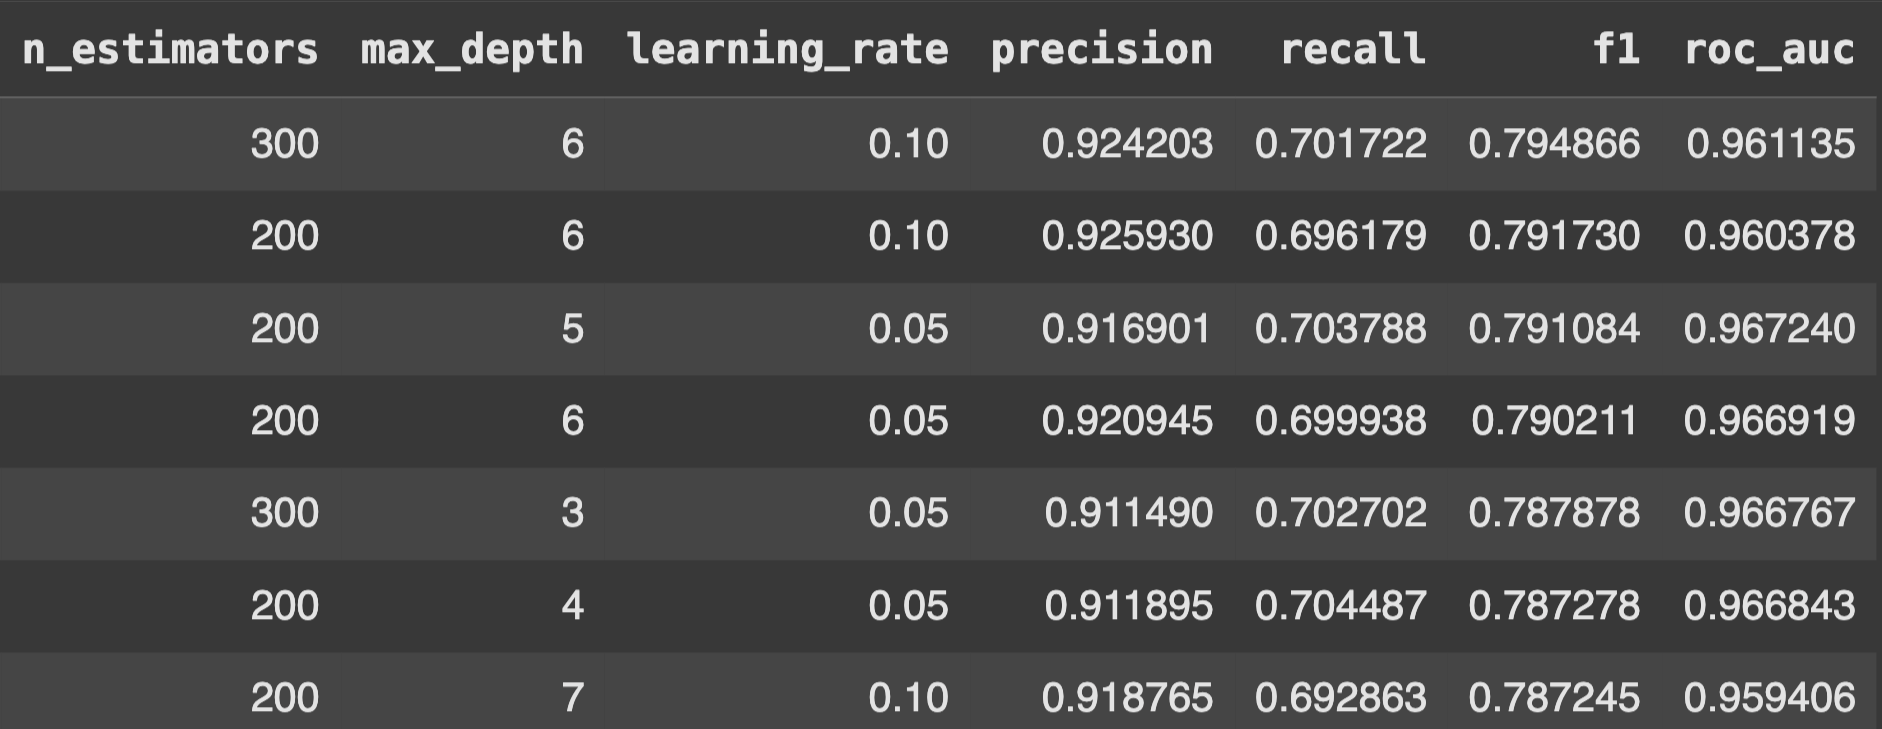

In [258]:
xgbc = xgb.XGBClassifier(n_estimators = 300, max_depth = 6, learning_rate = 0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 39, shuffle = False)
scaler = RobustScaler()
X_train[['Time', 'Amount_Category']] = scaler.fit_transform(X_train[['Time', 'Amount_Category']])
X_test[['Time', 'Amount_Category']] = scaler.transform(X_test[['Time', 'Amount_Category']])
xgbc.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [261]:
def plot_feature_importance(model, feature_names, importance_type='gain', top_n=None, figsize=(10,6)):
    fmap = dict(zip(feature_names, model.get_booster().get_score(importance_type=importance_type).values()))
    feature_imp = pd.DataFrame({
        'Feature': list(model.get_booster().get_score(importance_type=importance_type).keys()),
        'Importance': list(model.get_booster().get_score(importance_type=importance_type).values())
    }).sort_values('Importance', ascending=False)

    if top_n is not None:
        feature_imp = feature_imp.head(top_n)

    plt.figure(figsize=figsize)
    sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')
    plt.title(f'Feature Importances (XGBoost, type={importance_type})')
    plt.xlabel(importance_type.capitalize())
    plt.tight_layout()
    plt.show()

    return feature_imp

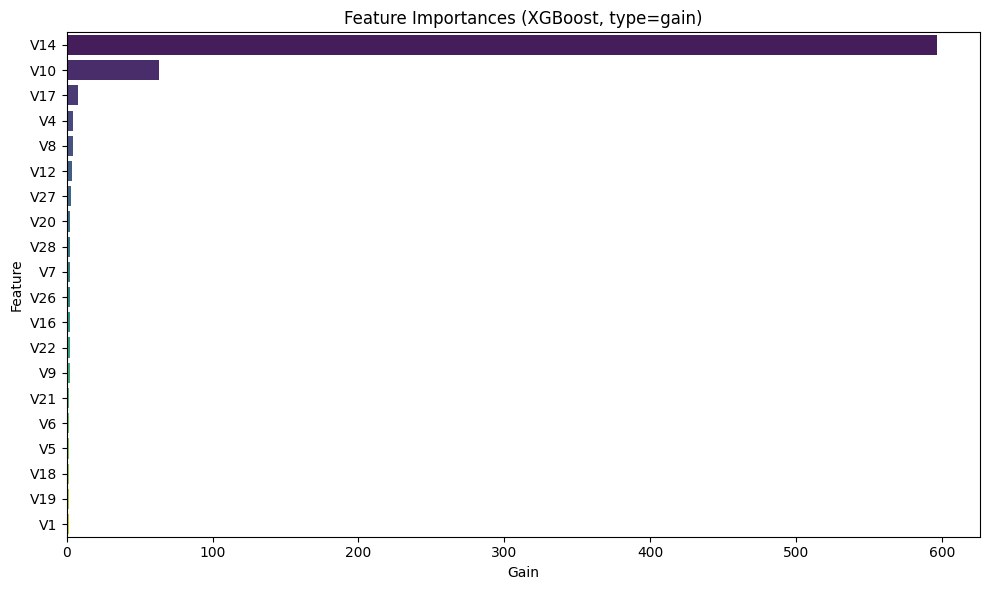

In [264]:
# Список имён признаков, соответствующих столбцам X_train
feature_names = X_train.columns.tolist()

# Вызов функции
feature_importances_df = plot_feature_importance(xgbc, feature_names, top_n=20, importance_type='gain')

Информационный выигрыш больше всего от осей V14, 10, 17

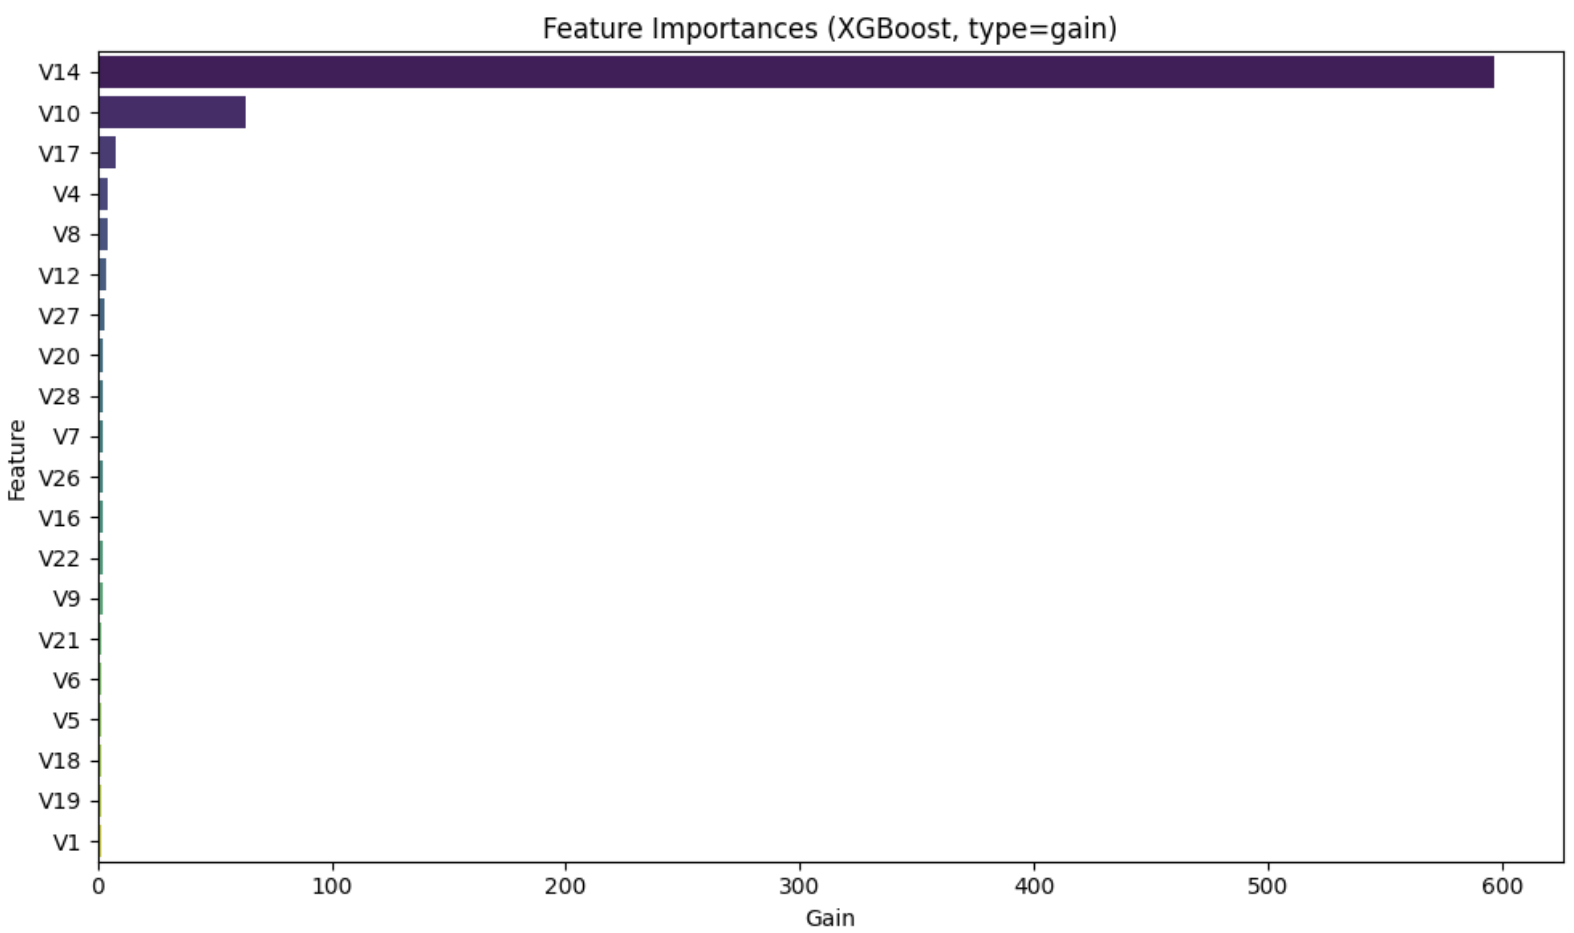

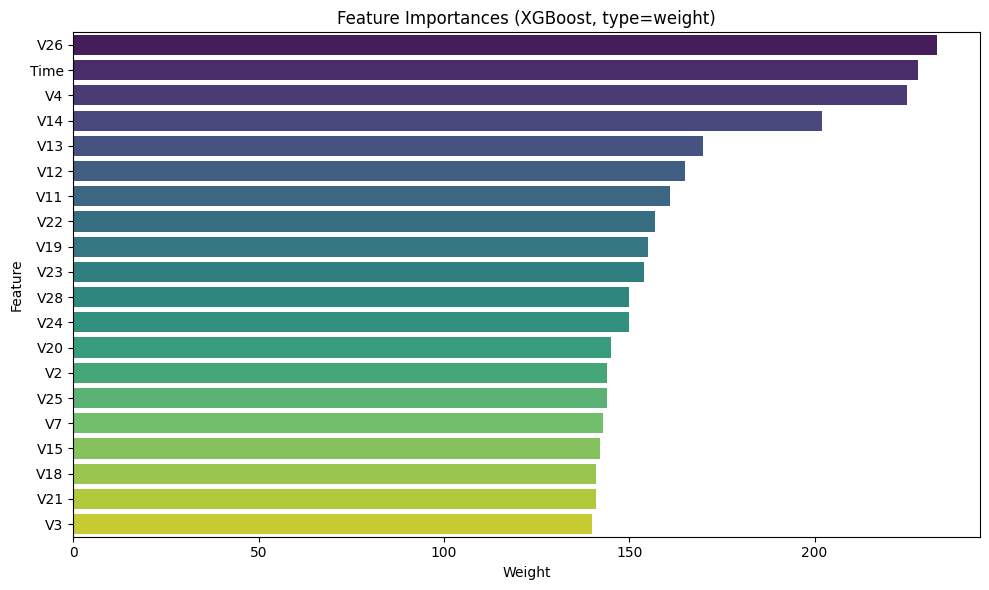

In [265]:
feature_importances_df = plot_feature_importance(xgbc, feature_names, top_n=20, importance_type='weight')

А вот по частоте использования лидируют v26, time, v4, v14.

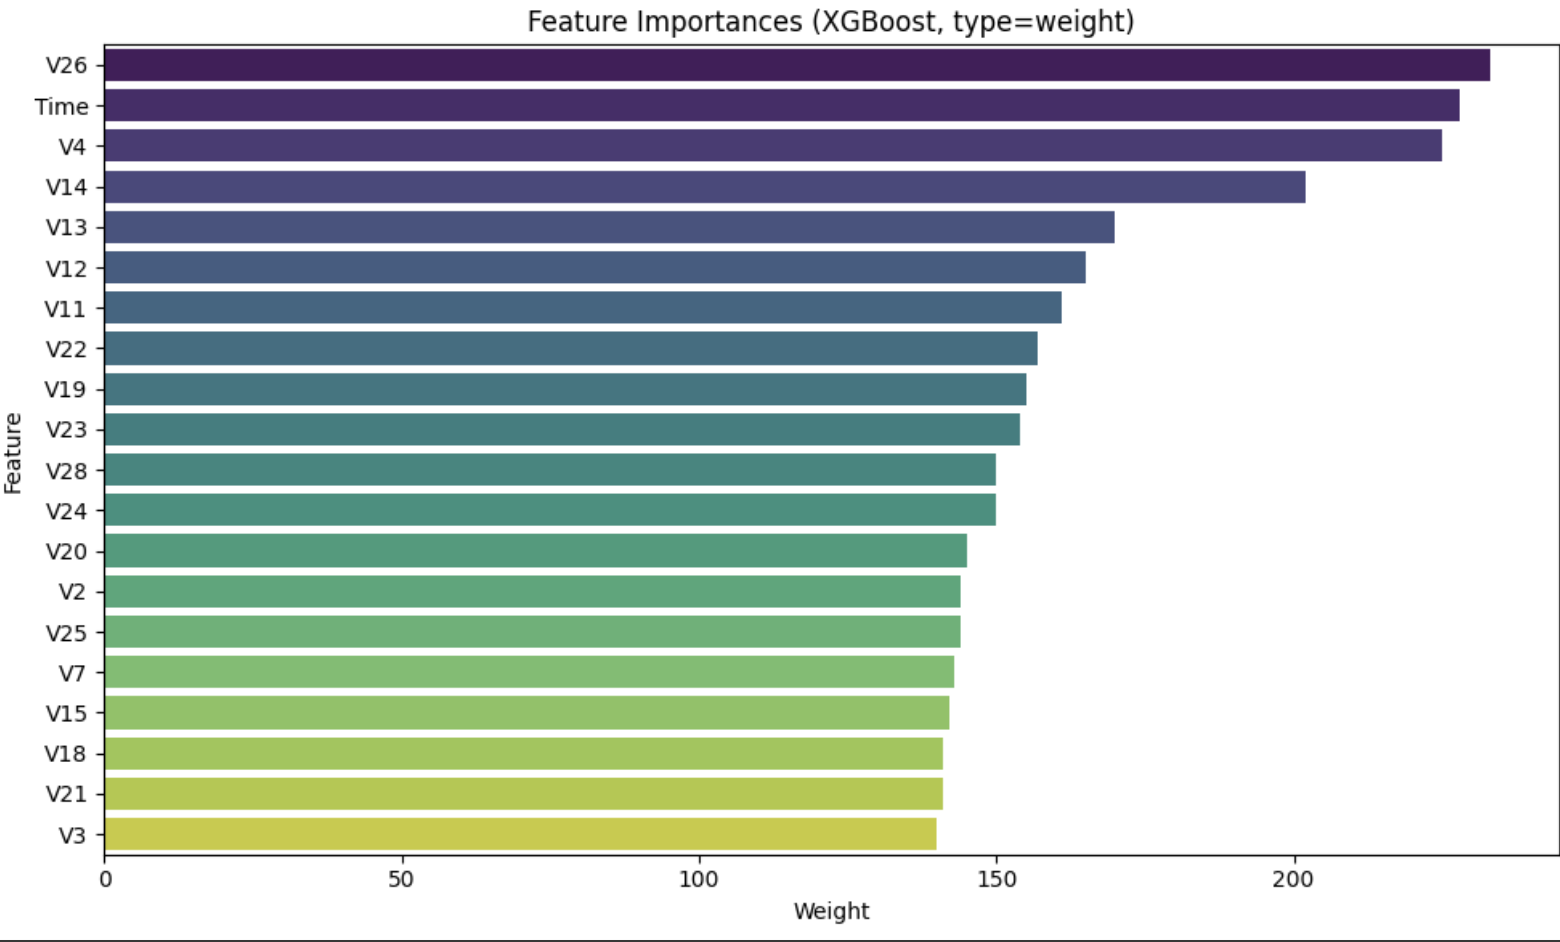

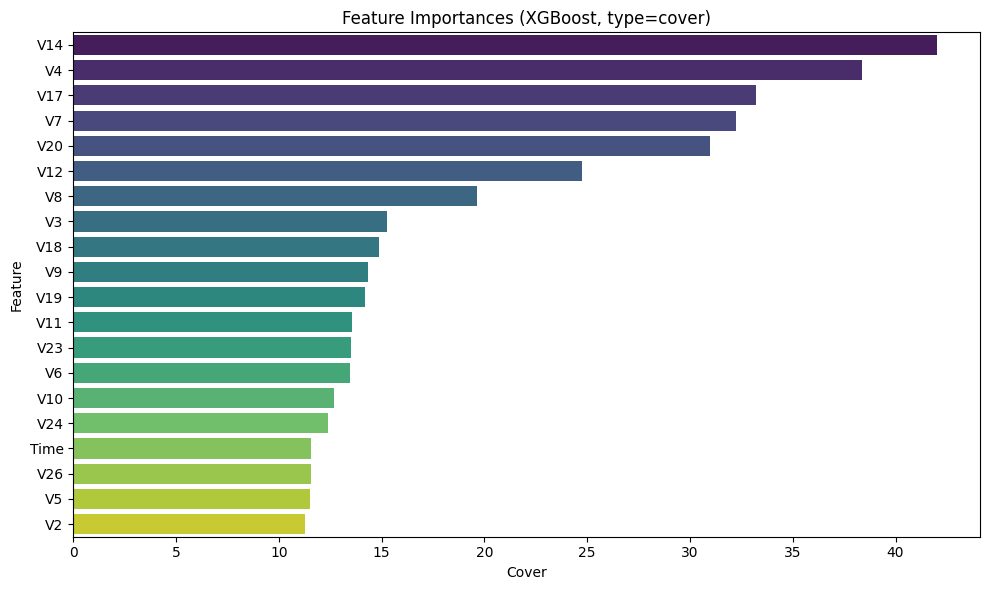

In [266]:
feature_importances_df = plot_feature_importance(xgbc, feature_names, top_n=20, importance_type='cover')

По охвату сэмплов затронутых признаком лидируют v14, v4, v17, v7.

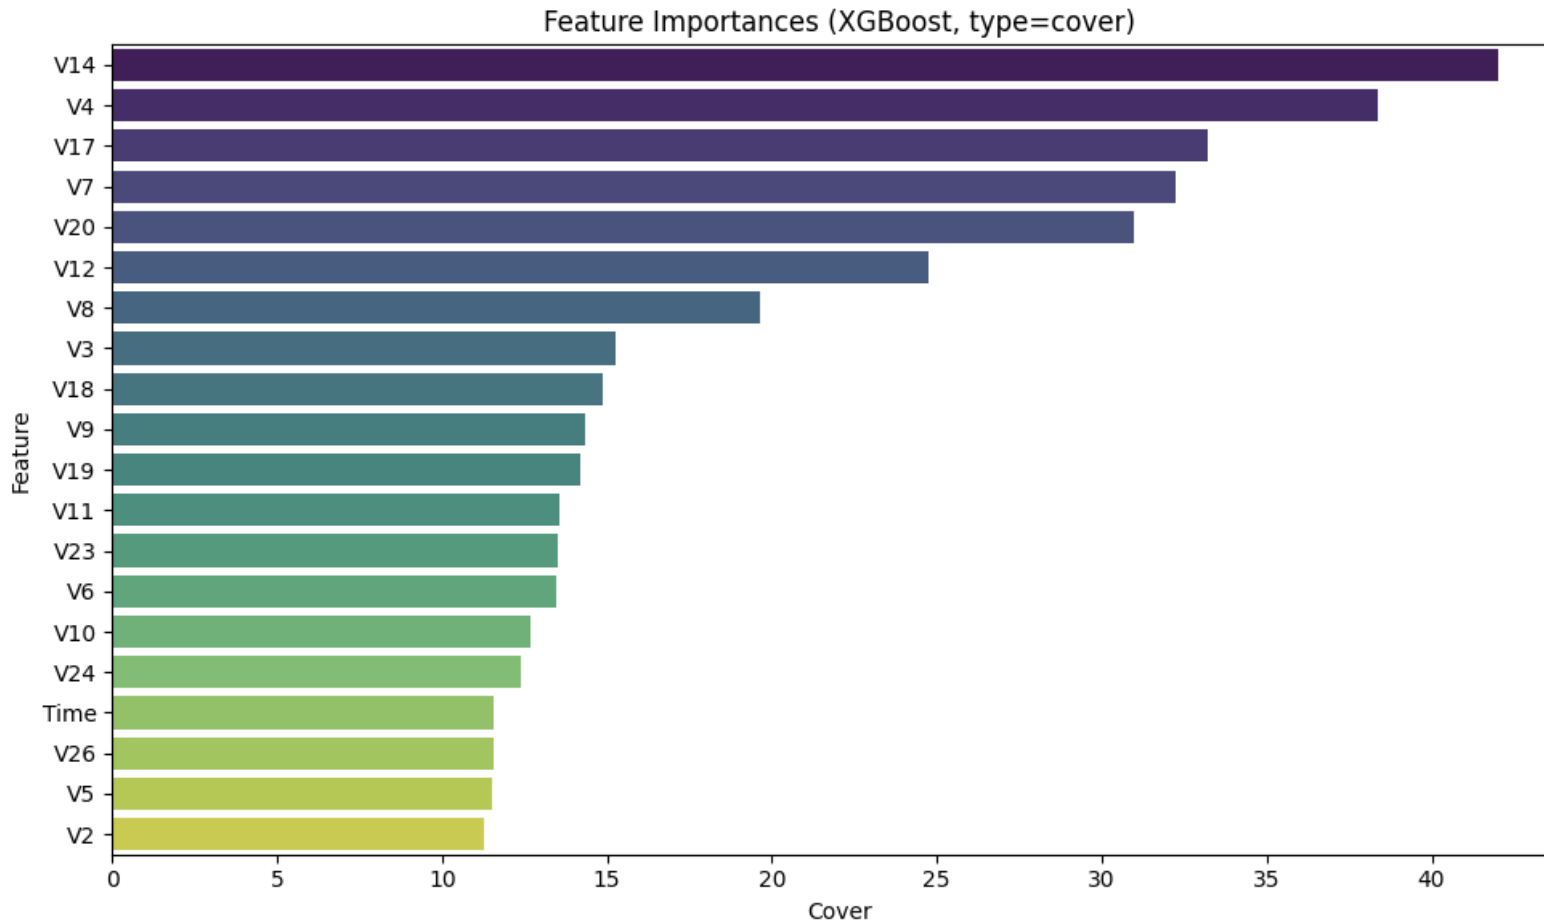